In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr

import statistics as stats
import matplotlib as mpl

from matplotlib import colorbar
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature  
from cartopy.util import add_cyclic_point
import cmocean

from glob import glob
import xclim

import netCDF4 as nc

from xclim.ensembles import create_ensemble
from xclim import ensembles
mpl.rcParams['figure.figsize'] = [10,4]
mpl.rcParams['figure.dpi'] = 500
mpl.rcParams['savefig.dpi'] = 500

mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['lines.linewidth']= 2.0

### Bias Correction Test

Bias-Corrected = Observational Climatology + (CESM Future - CESM Historical)

First step: CESM Future - CESM Historical

ssp2-4.5

Air Max 2040

In [2]:
CESM_Future = xr.open_dataset('/glade/work/kasante/MANGROVE_SDM/BioOracle_Files/AirTemperature_Surface_Ltmax_2040-2049.nc')['TS']
CESM_Historical = xr.open_dataset('/glade/work/kasante/MANGROVE_SDM/BioOracle_Files/AirTemperature_Surface_Ltmax_2010-2020.nc')['TS']

In [3]:
BioOracle_air = rxr.open_rasterio("AirTemperature Surface Ltmax 2010-2020.tif", masked=True)

Compute Delta (Δ)

In [4]:
Δ_ssp = CESM_Future - CESM_Historical
Δ_ssp

<xarray.DataArray 'TS' (lat: 192, lon: 288)>
array([[ 0.33137512,  0.3314972 ,  0.33139038, ...,  0.33140564,
         0.33139038,  0.33140564],
       [ 0.43899536,  0.43655396,  0.42912292, ...,  0.46029663,
         0.45414734,  0.44688416],
       [ 0.5790558 ,  0.5731964 ,  0.5649414 , ...,  0.56889343,
         0.5797577 ,  0.57580566],
       ...,
       [-0.01828003, -0.01785278, -0.01742554, ..., -0.01977539,
        -0.01928711, -0.01870728],
       [-0.00790405, -0.00805664, -0.00811768, ..., -0.00747681,
        -0.00765991, -0.00775146],
       [-0.00213623, -0.00213623, -0.00210571, ..., -0.00216675,
        -0.00216675, -0.00213623]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

In [5]:
Δ_ssp.to_netcdf('Delta_Air_Max_2040.nc')

#### Regridding

Checking for dimensions of tiff file 

In [6]:
BioOracle_air.shape

(1, 3600, 7200)

In [7]:
BioOracle_air.rio.bounds()

(-180.00000762939453, -90.00000000000003, 180.00000762939453, 90.0)

In [8]:
BioOracle_air.dtype

dtype('float32')

In [9]:
# Create 1D lat/lon from the coordinate values
lat = BioOracle_air.y.values
lon = BioOracle_air.x.values

# Create dummy data array
dummy_data = np.zeros((len(lat), len(lon)), dtype=np.float32)

# Create Dataset with CF-compliant attributes
ds_grid = xr.Dataset(
    {
        "grid": (("lat", "lon"), dummy_data)
    },
    coords={
        "lat": ("lat", lat, {
            "standard_name": "latitude",
            "units": "degrees_north"
        }),
        "lon": ("lon", lon, {
            "standard_name": "longitude",
            "units": "degrees_east"
        }),
    },
)

ds_grid.to_netcdf("biooracle_air_max_grid.nc")

In [10]:
air_max_grid = xr.open_dataset('/glade/work/kasante/MANGROVE_SDM/BioOracle_Files/biooracle_air_max_grid.nc')
air_max_grid

<xarray.Dataset>
Dimensions:  (lat: 3600, lon: 7200)
Coordinates:
  * lat      (lat) float64 89.97 89.92 89.88 89.82 ... -89.88 -89.93 -89.98
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
Data variables:
    grid     (lat, lon) float32 ...

Use CDO in terminal to regrid delta to biooracle grid

Command: cdo remapbil,biooracle_air_max_grid.nc Delta_Air_Max_2040.nc Regridded_Delta_Air_Max_2040.nc✅

In [3]:
Δ_ssp_air_max_regridded = xr.open_dataset('Regridded_Delta_Air_Max_2040.nc')
Δ_ssp_air_max_regridded = Δ_ssp_air_max_regridded.rename({'lat': 'y', 'lon': 'x'})
Δ_ssp_air_max_regridded

<xarray.Dataset>
Dimensions:  (x: 7200, y: 3600)
Coordinates:
  * x        (x) float64 -180.0 -179.9 -179.9 -179.8 ... 179.8 179.9 179.9 180.0
  * y        (y) float64 89.97 89.92 89.88 89.82 ... -89.83 -89.88 -89.93 -89.98
Data variables:
    TS       (y, x) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.3.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Mar 24 17:32:31 2025: cdo remapbil,biooracle_air_max_gr...
    CDO:          Climate Data Operators version 2.3.0 (https://mpimet.mpg.de...

#### Bias Correction 

In [4]:
BioOracle_air = rxr.open_rasterio("AirTemperature Surface Ltmax 2010-2020.tif", masked=True)

Bias_corrected_ssp_air_max_2040 = BioOracle_air.squeeze() + Δ_ssp_air_max_regridded['TS']
Bias_corrected_ssp_air_max_2040

<xarray.DataArray (y: 3600, x: 7200)>
array([[0.9610449 , 0.96187985, 0.96285653, ..., 0.9628148 , 0.9619254 ,
        0.9625109 ],
       [0.9594607 , 0.95918363, 0.9588337 , ..., 0.9589329 , 0.95908934,
        0.95900226],
       [0.9581395 , 0.95728266, 0.95622903, ..., 0.9562625 , 0.9573003 ,
        0.9566711 ],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * y            (y) float64 89.97 89.92 89.88 89.82 ... -89.88 -89.93 -89.98
    spatial_ref  int64 0

In [5]:
Bias_corrected_ssp_air_max_2040.shape

(3600, 7200)

In [6]:
Bias_corrected_ssp_air_max_2040.min()

<xarray.DataArray ()>
array(-7.80711746)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

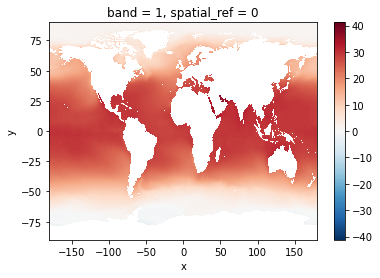

In [7]:
Bias_corrected_ssp_air_max_2040.plot()

In [8]:
# Save the bias-corrected file
Bias_corrected_ssp_air_max_2040.rio.write_crs("EPSG:4326", inplace=True)
Bias_corrected_ssp_air_max_2040.rio.to_raster("BiasCorrected_AirTemperature_Surface_Ltmax_2040-2049.tif")

ERROR 1: PROJ: internal_proj_create_from_database: /glade/u/apps/opt/conda/envs/npl-2022b/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.


#### Compare Dimensions 

Bias Corrected file (Air max 2040)

In [13]:
Bias_corrected_air_max_ssp_2040 = rxr.open_rasterio('/glade/work/kasante/MANGROVE_SDM/BioOracle_Files/BiasCorrected_AirTemperature_Surface_Ltmax_2040-2049.tif', masked=True)

In [14]:
Bias_corrected_air_max_ssp_2040.shape

(1, 3600, 7200)

In [15]:
Bias_corrected_air_max_ssp_2040.rio.bounds()

(-180.00000762939453, -90.00000000000003, 180.00000762939453, 90.0)

In [16]:
Bias_corrected_air_max_ssp_2040.rio.crs

ERROR 1: PROJ: internal_proj_identify: /glade/u/apps/opt/conda/envs/npl-2022b/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.


CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]')

BioOracle file (Air max 2010)

In [18]:
BioOracle_air_max = rxr.open_rasterio("AirTemperature Surface Ltmax 2010-2020.tif", masked=True)

In [19]:
BioOracle_air_max.shape

(1, 3600, 7200)

In [20]:
BioOracle_air_max.rio.bounds()

(-180.00000762939453, -90.00000000000003, 180.00000762939453, 90.0)

In [21]:
BioOracle_air_max.rio.crs

ERROR 1: PROJ: internal_proj_identify: /glade/u/apps/opt/conda/envs/npl-2022b/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.


CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]')

....................................................................................................................................................................................................................................................................................................................................................................................

Air Max 2050

In [22]:
CESM_Future = xr.open_dataset('/glade/work/kasante/MANGROVE_SDM/BioOracle_Files/AirTemperature_Surface_Ltmax_2050-2059.nc')['TS']
CESM_Historical = xr.open_dataset('/glade/work/kasante/MANGROVE_SDM/BioOracle_Files/AirTemperature_Surface_Ltmax_2010-2020.nc')['TS']

In [23]:
Δ_ssp = CESM_Future - CESM_Historical
Δ_ssp

<xarray.DataArray 'TS' (lat: 192, lon: 288)>
array([[ 1.4783630e+00,  1.4783936e+00,  1.4784088e+00, ...,
         1.4783478e+00,  1.4783478e+00,  1.4783936e+00],
       [ 1.3594360e+00,  1.3544464e+00,  1.3509521e+00, ...,
         1.3700867e+00,  1.3717499e+00,  1.3664856e+00],
       [ 1.2943878e+00,  1.2899475e+00,  1.2897186e+00, ...,
         1.2718201e+00,  1.2937469e+00,  1.2954407e+00],
       ...,
       [-1.6174316e-03, -7.0190430e-04,  3.3569336e-04, ...,
        -5.2795410e-03, -3.9978027e-03, -2.7160645e-03],
       [ 2.2186279e-02,  2.2186279e-02,  2.2155762e-02, ...,
         2.2521973e-02,  2.2338867e-02,  2.2277832e-02],
       [ 2.9052734e-02,  2.9052734e-02,  2.9144287e-02, ...,
         2.8961182e-02,  2.9022217e-02,  2.9022217e-02]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

In [24]:
Δ_ssp.to_netcdf('Delta_Air_Max_2050.nc')

In [25]:
Δ_ssp_air_max_regridded = xr.open_dataset('Regridded_Delta_Air_Max_2050.nc')
Δ_ssp_air_max_regridded = Δ_ssp_air_max_regridded.rename({'lat': 'y', 'lon': 'x'})
Δ_ssp_air_max_regridded

<xarray.Dataset>
Dimensions:  (x: 7200, y: 3600)
Coordinates:
  * x        (x) float64 -180.0 -179.9 -179.9 -179.8 ... 179.8 179.9 179.9 180.0
  * y        (y) float64 89.97 89.92 89.88 89.82 ... -89.83 -89.88 -89.93 -89.98
Data variables:
    TS       (y, x) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.3.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Mar 24 18:23:16 2025: cdo remapbil,biooracle_air_max_gr...
    CDO:          Climate Data Operators version 2.3.0 (https://mpimet.mpg.de...

In [26]:
Bias_corrected_ssp_air_max_2050 = BioOracle_air.squeeze() + Δ_ssp_air_max_regridded['TS']
Bias_corrected_ssp_air_max_2050

<xarray.DataArray (y: 3600, x: 7200)>
array([[0.9949719 , 0.9958046 , 0.996779  , ..., 0.9967486 , 0.99585694,
        0.9964401 ],
       [0.99373925, 0.9934603 , 0.9931085 , ..., 0.99321723, 0.9933717 ,
        0.9932827 ],
       [0.99276954, 0.9919113 , 0.9908562 , ..., 0.9908974 , 0.9919336 ,
        0.9913028 ],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * y            (y) float64 89.97 89.92 89.88 89.82 ... -89.88 -89.93 -89.98
    spatial_ref  int64 0

In [27]:
Bias_corrected_ssp_air_max_2050.min()

<xarray.DataArray ()>
array(-7.49399471)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

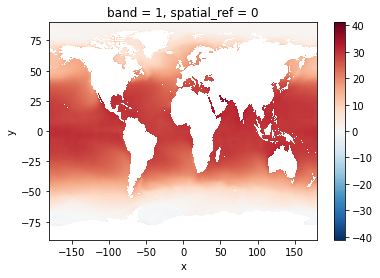

In [28]:
Bias_corrected_ssp_air_max_2050.plot();

In [29]:
Bias_corrected_ssp_air_max_2050.rio.write_crs("EPSG:4326", inplace=True)
Bias_corrected_ssp_air_max_2050.rio.to_raster("BiasCorrected_AirTemperature_Surface_Ltmax_2050-2059.tif")

ERROR 1: PROJ: internal_proj_create_from_database: /glade/u/apps/opt/conda/envs/npl-2022b/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.


In [31]:
Bias_corrected_air_max_ssp_2050 = rxr.open_rasterio('/glade/work/kasante/MANGROVE_SDM/BioOracle_Files/BiasCorrected_AirTemperature_Surface_Ltmax_2050-2059.tif', masked=True)

In [32]:
Bias_corrected_air_max_ssp_2050.shape

(1, 3600, 7200)

In [33]:
Bias_corrected_air_max_ssp_2050.rio.bounds()

(-180.00000762939453, -90.00000000000003, 180.00000762939453, 90.0)

In [34]:
Bias_corrected_air_max_ssp_2050.rio.crs

ERROR 1: PROJ: internal_proj_identify: /glade/u/apps/opt/conda/envs/npl-2022b/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.


CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]')

### Double Checking!

#### Δ Air Max 2040 (Before Regridding)

In [2]:
Δ_ssp_2040 = xr.open_dataset('/glade/work/kasante/MANGROVE_SDM/BioOracle_Files/Delta_Air_Max_2040.nc')
Δ_ssp_2040

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    TS       (lat, lon) float32 ...

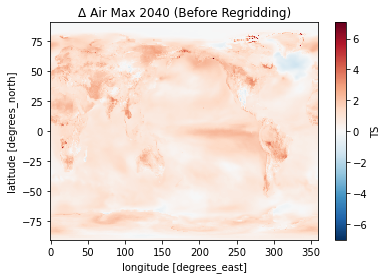

In [35]:
Δ_ssp_2040['TS'].plot(); plt.title("Δ Air Max 2040 (Before Regridding)");

#### BioOracle Air Max Grid - Grid Used

In [5]:
Air_Max_Grid = xr.open_dataset('/glade/work/kasante/MANGROVE_SDM/BioOracle_Files/biooracle_air_max_grid.nc')
Air_Max_Grid

<xarray.Dataset>
Dimensions:  (lat: 3600, lon: 7200)
Coordinates:
  * lat      (lat) float64 89.97 89.92 89.88 89.82 ... -89.88 -89.93 -89.98
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
Data variables:
    grid     (lat, lon) float32 ...

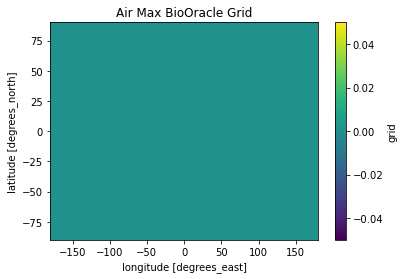

In [41]:
Air_Max_Grid['grid'].plot();plt.title("Air Max BioOracle Grid");

#### The grid is all zeros (as it was originally created just for regridding)

In [46]:
Air_Max_Grid.values()

ValuesView(<xarray.Dataset>
Dimensions:  (lat: 3600, lon: 7200)
Coordinates:
  * lat      (lat) float64 89.97 89.92 89.88 89.82 ... -89.88 -89.93 -89.98
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
Data variables:
    grid     (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0)

### After Regridding 

#### Bias Corrected Air Max 2040

In [19]:
Bias_corrected_ssp_air_max_2040 = rxr.open_rasterio("/glade/work/kasante/MANGROVE_SDM/BioOracle_Files/BiasCorrected_AirTemperature_Surface_Ltmax_2040-2049.tif", masked=True)
Bias_corrected_ssp_air_max_2040

<xarray.DataArray (band: 1, y: 3600, x: 7200)>
[25920000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * y            (y) float64 89.97 89.92 89.88 89.82 ... -89.88 -89.93 -89.98
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [28]:
print("Maximum :", float(Bias_corrected_ssp_air_max_2040.max()))
print("Minimum :", float(Bias_corrected_ssp_air_max_2040.min()))
print("Mean :", float(Bias_corrected_ssp_air_max_2040.mean()))
print("Standard Deviation :", float(Bias_corrected_ssp_air_max_2040.std()))

Maximum : 41.244598388671875
Minimum : -7.807117462158203
Mean : 16.627838134765625
Standard Deviation : 10.919569969177246


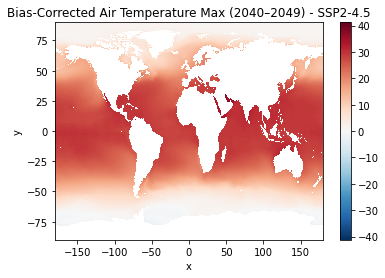

In [31]:
Bias_corrected_ssp_air_max_2040.plot(); plt.title("Bias-Corrected Air Temperature Max (2040–2049) - SSP2-4.5");

#### BioOracle Air Max

In [12]:
BioOracle_air = rxr.open_rasterio("AirTemperature Surface Ltmax 2010-2020.tif", masked=True)
BioOracle_air

<xarray.DataArray (band: 1, y: 3600, x: 7200)>
[25920000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * y            (y) float64 89.97 89.92 89.88 89.82 ... -89.88 -89.93 -89.98
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  40.044853210449
    STATISTICS_MEAN:     -9999
    STATISTICS_MINIMUM:  -8.3279104232788
    STATISTICS_STDDEV:   -9999
    scale_factor:        1.0
    add_offset:          0.0

In [29]:
print("Maximum :", float(BioOracle_air.max()))
print("Minimum :", float(BioOracle_air.min()))
print("Mean :", float(BioOracle_air.mean()))
print("Standard Deviation :", float(BioOracle_air.std()))

Maximum : 40.04485321044922
Minimum : -8.327910423278809
Mean : 15.917383193969727
Standard Deviation : 10.779809951782227


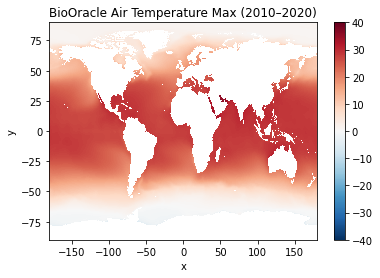

In [32]:
BioOracle_air.plot(); plt.title("BioOracle Air Temperature Max (2010–2020)");

### Δ Air Max 2050 (Before Regridding)

In [33]:
Δ_ssp_2050 = xr.open_dataset('/glade/work/kasante/MANGROVE_SDM/BioOracle_Files/Delta_Air_Max_2050.nc')
Δ_ssp_2050

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    TS       (lat, lon) float32 ...

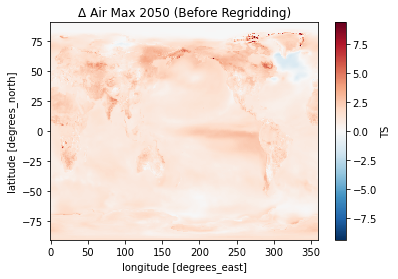

In [36]:
Δ_ssp_2050['TS'].plot(); plt.title("Δ Air Max 2050 (Before Regridding)");

In [37]:
Bias_corrected_ssp_air_max_2050 = rxr.open_rasterio("/glade/work/kasante/MANGROVE_SDM/BioOracle_Files/BiasCorrected_AirTemperature_Surface_Ltmax_2050-2059.tif", masked=True)
Bias_corrected_ssp_air_max_2050

<xarray.DataArray (band: 1, y: 3600, x: 7200)>
[25920000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * y            (y) float64 89.97 89.92 89.88 89.82 ... -89.88 -89.93 -89.98
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [38]:
print("Maximum :", float(Bias_corrected_ssp_air_max_2050.max()))
print("Minimum :", float(Bias_corrected_ssp_air_max_2050.min()))
print("Mean :", float(Bias_corrected_ssp_air_max_2050.mean()))
print("Standard Deviation :", float(Bias_corrected_ssp_air_max_2050.std()))

Maximum : 41.1795654296875
Minimum : -7.49399471282959
Mean : 16.87340545654297
Standard Deviation : 10.933688163757324


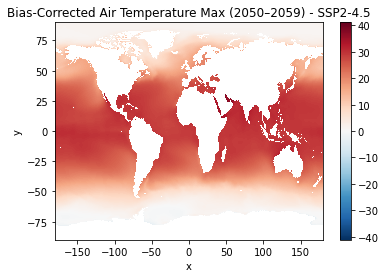

In [39]:
Bias_corrected_ssp_air_max_2050.plot(); plt.title("Bias-Corrected Air Temperature Max (2050–2059) - SSP2-4.5");